# Outline of the lab:
    1 We see how a simple ANN solves MNIST classification
    2 We do the same task using a discriminative Predictive Coding Network (PCN)
    3 We use a generative PCN to try and solve MNIST
    
In all cases we are doing supervised learning - we train the model by giving it images and true labels, and then test it by presenting test images and asking it to predict the image labels

Also in all cases, the label is represented by 10 nodes - one for each possible value.  Thus the true label is a one-hot vector.  The training of the algorithms tries to achieve this one hot representation, but the actual inferred label vectors will not be one-hot.  Inferred labels are chosen by taking the node with the maximum value.

# 1 . We first run a simple ANN to classify MNIST images using backprop


Starting training
Epoch 1 complete. Test accuracy 91.81%
Epoch 2 complete. Test accuracy 94.35%
Epoch 3 complete. Test accuracy 95.34%
Epoch 4 complete. Test accuracy 95.99%
Epoch 5 complete. Test accuracy 96.84%
Epoch 6 complete. Test accuracy 97.03%
Epoch 7 complete. Test accuracy 97.25%
Epoch 8 complete. Test accuracy 97.33%
Epoch 9 complete. Test accuracy 97.57%
Epoch 10 complete. Test accuracy 97.76%
Finished


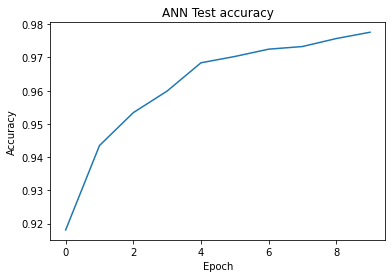

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

'''
Learning a simple ANN to classify MNIST images
'''

# --- Data ---
transform = transforms.ToTensor()
train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train, batch_size=640, shuffle=True)
test_loader  = DataLoader(test, batch_size=10000, shuffle=False)

# --- Simple ANN ---
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        return self.net(x)

model = ANN()
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

# --- Training and Testing loop ---
print("Starting training")
accuracy_history=[]
for epoch in range(10):
    for x, y in train_loader:
        opt.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        opt.step()
            
    # --- Evaluation ---
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    test_accuracy=correct/total
    accuracy_history.append(test_accuracy)            
    print(f"Epoch {epoch+1} complete. Test accuracy {test_accuracy:.2%}")
print("Finished")

plt.figure()
plt.plot(accuracy_history)
plt.title("ANN Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

If you are not familiar with backpropagation and ANNs, make sure you understand what is happening above before proceeding.

# 2 Now we do the same thing using a discriminative PC.



Starting discriminative experiment --seed 1 --device cuda
Test @ epoch 1 / Accuracy: 90.96%
Test @ epoch 2 / Accuracy: 93.77%
Test @ epoch 3 / Accuracy: 94.82%
Test @ epoch 4 / Accuracy: 95.46%
Test @ epoch 5 / Accuracy: 95.89%
Test @ epoch 6 / Accuracy: 96.18%
Test @ epoch 7 / Accuracy: 96.45%
Test @ epoch 8 / Accuracy: 96.60%
Test @ epoch 9 / Accuracy: 96.75%
Test @ epoch 10 / Accuracy: 96.89%


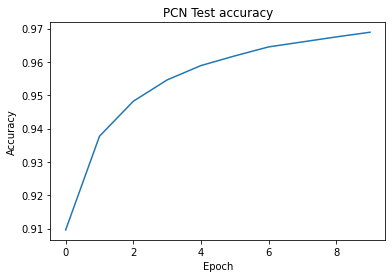

In [2]:

import sys
import pathlib
import matplotlib.pyplot as plt
import torch
#sys.path.append(str(pathlib.Path(__file__).parent.parent))
sys.path.append(str(pathlib.Path().resolve().parent))
from pypc import utils
from pypc import datasets
from pypc import optim
from pypc.models import PCModel


def main(cf):
    print(f"\nStarting discriminative experiment --seed {cf.seed} --device {utils.DEVICE}")
    utils.seed(cf.seed)

    train_dataset = datasets.MNIST(
        train=True, scale=cf.label_scale, size=cf.train_size, normalize=cf.normalize
    )
    test_dataset = datasets.MNIST(
        train=False, scale=cf.label_scale, size=cf.test_size, normalize=cf.normalize
    )
    train_loader = datasets.get_dataloader(train_dataset, cf.batch_size)
    test_loader = datasets.get_dataloader(test_dataset, cf.test_size)#cf.batch_size)

    model = PCModel(
        nodes=cf.nodes,
        mu_dt=cf.mu_dt,
        act_fn=cf.act_fn,
        use_bias=cf.use_bias,
        kaiming_init=cf.kaiming_init,
    )
    optimizer = optim.get_optim(
        model.params,
        cf.optim,
        cf.lr,
        batch_scale=cf.batch_scale,
        grad_clip=cf.grad_clip,
        weight_decay=cf.weight_decay,
    )

    with torch.no_grad():
        metrics = {"acc": []}
        for epoch in range(1, cf.n_epochs + 1):

            #print(f"\nTrain @ epoch {epoch} ({len(train_loader)} batches)")
            for batch_id, (img_batch, label_batch) in enumerate(train_loader):
                model.train_batch_supervised(
                    img_batch, label_batch, cf.n_train_iters, fixed_preds=cf.fixed_preds_train
                )

                optimizer.step(
                    curr_epoch=epoch,
                    curr_batch=batch_id,
                    n_batches=len(train_loader),
                    batch_size=img_batch.size(0),
                )
            if epoch % cf.test_every == 0:
                acc = 0
                for _, (img_batch, label_batch) in enumerate(test_loader):
                    label_preds = model.test_batch_supervised(img_batch)
                    acc += datasets.accuracy(label_preds, label_batch)
                metrics["acc"].append(acc / len(test_loader))
                print("Test @ epoch {} / Accuracy: {:.2%}".format(epoch, acc / len(test_loader)))


    plt.figure()
    plt.plot(metrics["acc"])
    plt.title("PCN Test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()


if __name__ == "__main__":
    cf = utils.AttrDict()
    cf.seeds = [1]

    for seed in cf.seeds:

        # experiment params
        cf.seed = seed
        cf.n_epochs = 10
        cf.test_every = 1

        # dataset params
        cf.train_size = None
        cf.test_size = 10000
        cf.label_scale = None
        cf.normalize = False

        # optim params
        cf.optim ="Adam" # "SGD" # 
        cf.lr = 1e-3
        cf.batch_size = 640
        cf.batch_scale = False
        cf.grad_clip = 50
        cf.weight_decay = None

        # inference params
        cf.mu_dt = 0.01
        cf.n_train_iters = 10
        cf.fixed_preds_train =  False

        # model params
        cf.use_bias = True
        cf.kaiming_init = False
        cf.nodes = [784, 300, 100, 10] # mnist and fashiomnist  28*28
        cf.act_fn = utils.Tanh()

        main(cf)


# Questions on discriminative PCN experiment
    Analyse the code for PCN.  
    Note the order in which the layers are presented in cf.nodes (input layer is presented first).  Is this inside-out or outside in?  
    What does train_batch_supervised method do?
    What does test_batch_supervised method do?
    Try to relate this to the gradient update equations from the lecture.
    One of these methods is a lot slower than the other. Which? Why? (Strong hint - note the value of cf.n_train_iters).
    Try playing with some parameter values and seeing what impact they have. In particular:
         - run for more training epochs
         - cf.n_train_iters. eg try 1,2,10, 20
    

# 3 Now we do the same thing using a generative PC.


Starting generative experiment --seed 1 --device cuda
Test @ epoch 1 / Accuracy: 83.88%
Test @ epoch 2 / Accuracy: 84.76%
Test @ epoch 3 / Accuracy: 84.77%
Test @ epoch 4 / Accuracy: 84.48%
Test @ epoch 5 / Accuracy: 84.56%


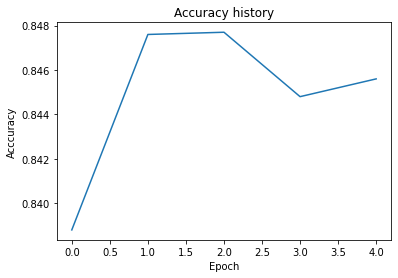

In [3]:
import sys
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np
#sys.path.append(str(pathlib.Path(__file__).parent.parent))
sys.path.append(str(pathlib.Path().resolve().parent))
from pypc import utils
from pypc import datasets
from pypc import optim
from pypc.models import PCModel


def plot_imgs(imgs, labels, title):
    img_titles=[str(labels[i]) for i in range(len(labels))]
    fig, axes = plt.subplots(2, 8)
    axes = axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img, cmap="gray")
        axes[i].set_axis_off()
        if i>=8:
            axes[i].set_title(img_titles[i-8], fontsize=12)
    fig.suptitle(title, fontsize=16) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()
    plt.close("all")    

def main(cf):
    print(f"\nStarting generative experiment --seed {cf.seed} --device {utils.DEVICE}")
    utils.seed(cf.seed)

    train_dataset = datasets.MNIST(train=True, scale=cf.label_scale, size=cf.train_size, normalize=cf.normalize)
    test_dataset = datasets.MNIST(train=False, scale=cf.label_scale, size=cf.test_size, normalize=cf.normalize)
    train_loader = datasets.get_dataloader(train_dataset, cf.train_batch_size)
    test_loader = datasets.get_dataloader(test_dataset, cf.test_batch_size)

    model = PCModel(
        nodes=cf.nodes, mu_dt=cf.mu_dt, act_fn=cf.act_fn, use_bias=cf.use_bias, kaiming_init=cf.kaiming_init
    )
    optimizer = optim.get_optim(
        model.params,
        cf.optim,
        cf.lr,
        batch_scale=cf.batch_scale,
        grad_clip=cf.grad_clip,
        weight_decay=cf.weight_decay,
    )

    with torch.no_grad():
        metrics = {"acc": [], "train_loss": []}
        
        for epoch in range(1, cf.n_epochs + 1):
            for batch_id, (img_batch, label_batch) in enumerate(train_loader):
                model.train_batch_generative(
                    img_batch, label_batch, cf.n_train_iters, fixed_preds=cf.fixed_preds_train
                )

                optimizer.step(
                    curr_epoch=epoch,
                    curr_batch=batch_id,
                    n_batches=len(train_loader),
                    batch_size=img_batch.size(0),
                )

            acc=0
            if epoch % cf.test_every == 0:
                if cf.increase_test_iters:
                    test_iters=int(cf.n_test_iters*(1+epoch/10)) # gradually increase test_iters with epoch
                    print("Number of test iterations increases with epochs: ", test_iters)
                else:
                    test_iters=cf.n_test_iters
                   
                for _, (img_batch, label_batch) in enumerate(test_loader):                    
                    label_preds = model.test_batch_generative(
                        img_batch, test_iters, fixed_preds=cf.fixed_preds_test,init_std=cf.init_std
                        )            
                    acc += datasets.accuracy(label_preds, label_batch)

                print("Test @ epoch {} / Accuracy: {:.2%}".format(epoch, acc / len(test_loader)))

                if cf.plot_sample_images:    
                    img_preds = model.forward(label_batch)
                    img_preds = img_preds.cpu().detach().numpy()
                    img_preds = img_preds[:8, :]
                    img_true=img_batch.cpu().detach().numpy()[:8,:]
                    img_combined = np.concatenate([img_true, img_preds], axis=0)
                    labels=np.argmax(label_batch.cpu().detach().numpy()[:8,:],axis=1)
                    imgs = [np.reshape(img_combined[i, :], [28, 28]) for i in range(img_combined.shape[0])]
                    plot_imgs(imgs, labels, "Epoch {} Top row is true image, \nbottom row is model generated from True Label".format(epoch))
                    
                    img_preds = model.forward(label_preds)
                    img_preds = img_preds.cpu().detach().numpy()
                    img_preds = img_preds[:8, :]
                    img_true=img_batch.cpu().detach().numpy()[:8,:]
                    img_combined = np.concatenate([img_true, img_preds], axis=0)
                    labels=np.argmax(label_preds.cpu().detach().numpy()[:8,:],axis=1)
                    imgs = [np.reshape(img_combined[i, :], [28, 28]) for i in range(img_combined.shape[0])]
                    plot_imgs(imgs,labels, "Epoch {} Top row is true image, \nbottom row is model generated from Inferred Label".format(epoch))

                    
            metrics["acc"].append(acc / len(test_loader))
           

        plt.figure()
        plt.plot(metrics['acc'])
        plt.title("Accuracy history")
        plt.ylabel("Acccuracy")
        plt.xlabel("Epoch")
        plt.show()

       
        

if __name__ == "__main__":
    cf = utils.AttrDict()
    cf.seeds = [1]

    for seed in cf.seeds:

        # experiment params
        cf.seed = seed
        cf.n_epochs =5
        cf.test_every = 1
        cf.plot_sample_images = False

        # dataset params
        cf.train_size = None
        cf.test_size = 10000
        cf.label_scale = None
        cf.normalize = True

        # optim params
        cf.optim = "Adam"
        cf.lr = 1e-3 
        cf.train_batch_size = 640
        cf.test_batch_size =10000
        cf.batch_scale = False
        cf.grad_clip = None
        cf.weight_decay = None
        
        # inference params
        cf.mu_dt = .01 
        cf.n_train_iters = 100 
        cf.n_test_iters =  500
        cf.increase_test_iters=False # later epochs use more test iterations
        cf.init_std = 0.01 
        cf.fixed_preds_train = False
        cf.fixed_preds_test = False

        # model params
        cf.use_bias = True
        cf.kaiming_init = False
        cf.nodes = [10,100,300,784]
        cf.act_fn = utils.Tanh()

        main(cf)

# Questions on generative PCN experiment

Analyse the code for generative PCN.  

Note the order in which the layers are presented in cf.nodes (input layer is presented first).  Is this inside-out or outside in?  

What does train_batch_generative method do? How does this differ from the discriminative case?

What does test_batch_generative method do? How does this differ from the discriminative case?

Try to relate this to the gradient update equations from the lecture.

Try playing with some parameter values and seeing what impact they have on accuracy. In particular:

- cf.n_train_iters. eg try 10 50 100 200 (if you have time!!)
    
- cf.n_test_iters. eg try 10 50 100 200 1000 
     
What are the advantanges of generative mode over discriminative? What are the disadvantages?

# Image generation
You should have noticed that, in order to produce a label for an image, the generative case requires iteration (due to the direction of the forward model).

On the other hand, it only takes a forward sweep to produce an image from a label.  

Now change cf.plot_sample_images = True.  On each test run, this will 
- produce a plot comparing some true images to the images produced by the model using the true label as input.  
- produce a plot comparing some true images to the images produced by the model, using the label which was inferred for that image

Consider the difference between these plots. Note in particular what happens in each case if there are different versions of the same image. Why is there a difference? What implications does that have for the ability of the model to do label inference ?

Suggest some ways to improve label inference in the generative case. And let me know if you have any good ideas!!! 